In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
%matplotlib inline
import os
import cv2

/home/yoda/tensorflow-1.9.0/local/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/yoda/tensorflow-1.9.0/local/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/yoda/tensorflow-1.9.0/local/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/yoda/tensorflow-1.9.0/local/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/home/yoda/tensorflow-1.9.0/local/l

### Read csv
a csv was made from xml file.

In [2]:
data = pd.read_csv('train_labels.csv')
data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_2464.JPG,378,504,king,27,85,174,261
1,IMG_2590.JPG,378,504,nine,185,89,276,215
2,IMG_2590.JPG,378,504,nine,29,332,159,440
3,IMG_2590.JPG,378,504,jack,83,143,216,269
4,IMG_2590.JPG,378,504,queen,189,289,332,416


In [3]:
print 'Total number of images : ', data["filename"].nunique()

Total number of images :  296


In [4]:
def change_to_xywh (data):
    data["x"] = data['xmin']
    data["y"] = data['ymin']
    data['w'] = data['xmax'] - data['xmin'] + 1
    data['h'] = data['ymax'] - data['ymin'] + 1
    data["ar"] = data["w"]/data["h"]
    
    return data

In [5]:
data = change_to_xywh(data)
data.head()

/home/yoda/tensorflow-1.9.0/local/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


,filename,width,height,class,xmin,ymin,xmax,ymax,x,y,w,h,ar
0,IMG_2464.JPG,378,504,king,27,85,174,261,27,85,148,177,0.836158
1,IMG_2590.JPG,378,504,nine,185,89,276,215,185,89,92,127,0.724409
2,IMG_2590.JPG,378,504,nine,29,332,159,440,29,332,131,109,1.201835
3,IMG_2590.JPG,378,504,jack,83,143,216,269,83,143,134,127,1.055118
4,IMG_2590.JPG,378,504,queen,189,289,332,416,189,289,144,128,1.125000


### Describe the dataset

In [7]:
data.describe()

,width,height,xmin,ymin,xmax,ymax,x,y,w,h,ar
count,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000
mean,480.182163,508.952562,161.091082,169.635674,308.554080,357.265655,161.091082,169.635674,148.462998,188.629981,0.824470
std,221.004063,22.680363,131.068885,87.936224,146.202463,92.654976,131.068885,87.936224,44.945532,57.973884,0.259569
min,378.000000,270.000000,1.000000,1.000000,56.000000,93.000000,1.000000,1.000000,43.000000,60.000000,0.296137
25%,378.000000,504.000000,69.000000,104.500000,206.500000,287.500000,69.000000,104.500000,115.000000,143.500000,0.724282
50%,378.000000,504.000000,124.000000,172.000000,279.000000,372.000000,124.000000,172.000000,149.000000,188.000000,0.773869
75%,378.000000,504.000000,208.000000,234.000000,346.500000,424.500000,208.000000,234.000000,176.000000,231.000000,0.889113
max,960.000000,540.000000,749.000000,443.000000,928.000000,540.000000,749.000000,443.000000,315.000000,352.000000,2.822581


## Find the optimum base anchor size
To find the best anchor size which will capture most of the object

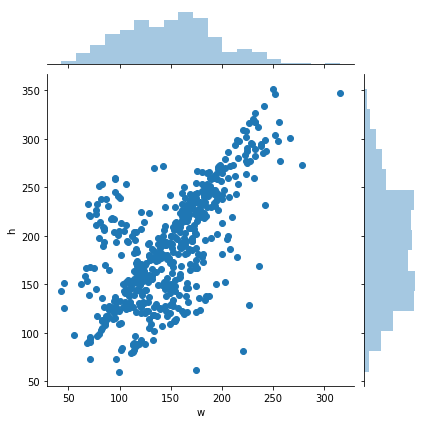

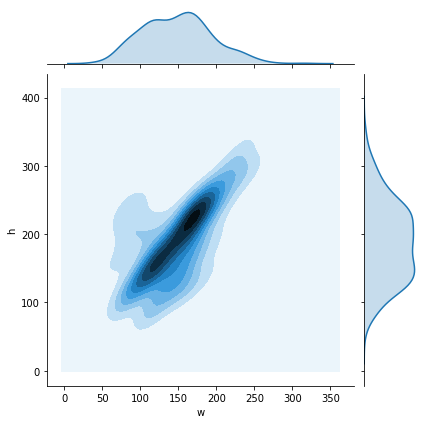

In [8]:
#Joint Plot of w and h
sns.jointplot(x="w", y="h", data=data)
sns.jointplot(x="w", y="h", data=data, kind='kde')

In [14]:
def count_base_size(width, height, input_array=[64,96,128,196,212,256,512]):
    result = {}
    for ele in input_array:
        result[str(ele)] = 0
    result['rest'] = 0
    
    import itertools
    for w,h in itertools.izip(width,height):
        done = False
        for inp in input_array:
            if w <= inp and h <= inp:
                result[str(inp)] += 1
                done = True
        if done == False:
            result['rest'] += 1
            
    return result
    
    

In [10]:
D = count_base_size(data["w"].tolist(), data["h"].tolist())
import collections
OD = collections.OrderedDict(sorted(D.items()))


### Bar graph

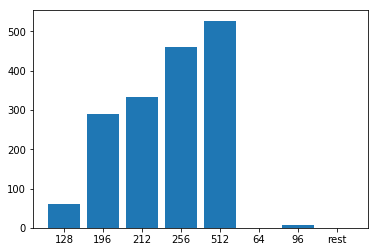

In [11]:
plt.bar(range(len(OD)), OD.values(), align='center')  # python 2.x
plt.xticks(range(len(OD)), OD.keys())  # in python 2.x

plt.show()

In [12]:
print OD

OrderedDict([('128', 61), ('196', 289), ('212', 334), ('256', 459), ('512', 527), ('64', 0), ('96', 6), ('rest', 0)])


### K-Means

In [13]:
#utility functions for K-means
import numpy as np


def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters


#Test

In [125]:
data['w_norm'] = data['w']/data['width']
data['h_norm'] = data['h']/data['height']

print data.columns[14:16]
data1 = data.as_matrix(columns=data.columns[14:16])
print data1

Index([u'w_norm', u'h_norm'], dtype='object')
[[0.39153439 0.35119048]
 [0.24338624 0.25198413]
 [0.34656085 0.21626984]
 ...
 [0.30952381 0.1765873 ]
 [0.3015873  0.16269841]
 [0.30687831 0.17063492]]


/home/yoda/tensorflow-1.9.0/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [132]:
CLUSTERS = 7
out = kmeans(data1, k=CLUSTERS)
print("Accuracy: {:.2f}%".format(avg_iou(data1, out) * 100))
print("Boxes:\n {}".format(out))


ratios = out[:,0]/out[:,1]
print ratios


Accuracy: 82.75%
Boxes:
 [[0.1859375  0.4212963 ]
 [0.32804233 0.28571429]
 [0.24338624 0.5037037 ]
 [0.51851852 0.49603175]
 [0.25396825 0.20833333]
 [0.44444444 0.36011905]
 [0.37037037 0.38293651]]
[0.44134615 1.14814815 0.48319328 1.04533333 1.21904762 1.23415978
 0.9671848 ]


In [72]:
base_box = 196*196
data['scale'] = data['w']*data['h']/(base_box)
data.describe()

,width,height,xmin,ymin,xmax,ymax,x,y,w,h,ar,scale
count,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000
mean,480.182163,508.952562,161.091082,169.635674,308.554080,357.265655,161.091082,169.635674,148.462998,188.629981,0.824470,0.773508
std,221.004063,22.680363,131.068885,87.936224,146.202463,92.654976,131.068885,87.936224,44.945532,57.973884,0.259569,0.443329
min,378.000000,270.000000,1.000000,1.000000,56.000000,93.000000,1.000000,1.000000,43.000000,60.000000,0.296137,0.134918
25%,378.000000,504.000000,69.000000,104.500000,206.500000,287.500000,69.000000,104.500000,115.000000,143.500000,0.724282,0.452637
50%,378.000000,504.000000,124.000000,172.000000,279.000000,372.000000,124.000000,172.000000,149.000000,188.000000,0.773869,0.649729
75%,378.000000,504.000000,208.000000,234.000000,346.500000,424.500000,208.000000,234.000000,176.000000,231.000000,0.889113,1.020369
max,960.000000,540.000000,749.000000,443.000000,928.000000,540.000000,749.000000,443.000000,315.000000,352.000000,2.822581,2.845299


### Experiment 2

Index([u'ar', u'scale'], dtype='object')
[[0.83615819 0.68190337]
 [0.72440945 0.30414411]
 [1.20183486 0.37169409]
 ...
 [1.31460674 0.27105893]
 [1.3902439  0.24333611]
 [1.34883721 0.25968347]]


/home/yoda/tensorflow-1.9.0/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


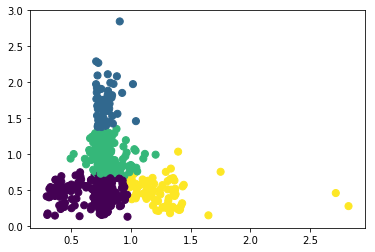

In [86]:
print data.columns[12:14]
X = data.as_matrix(columns=data.columns[12:14])
print X



from sklearn.cluster import KMeans
K = KMeans(4, random_state=0)
labels = K.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=labels.labels_,
            s=50, cmap='viridis');

In [87]:
labels.cluster_centers_

array([[0.68566896, 0.46003078],
       [0.78684081, 1.73446197],
       [0.79607361, 0.9927303 ],
       [1.25891568, 0.47614895]])

#### Spectral Clusterring

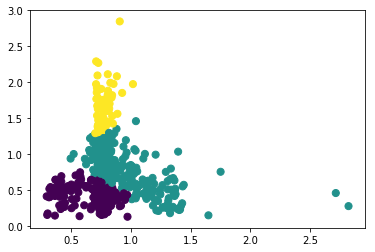

In [93]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=3, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels1 = model.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=labels1.labels_,
            s=50, cmap='viridis');

## Experiment 3

In [135]:
# 1 class AR
X = data.iloc[:,12].values
X = X.reshape(-1,1)



from sklearn.cluster import KMeans
K = KMeans(4, random_state=0)
labels = K.fit(X)


In [136]:
labels.cluster_centers_


array([[0.44523506],
       [1.20418889],
       [0.78297542],
       [2.76931501]])

In [133]:
# 1 class Sclae
X = data.iloc[:,13].values
X = X.reshape(-1,1)



from sklearn.cluster import KMeans
K = KMeans(4, random_state=0)
labels = K.fit(X)


In [134]:
labels.cluster_centers_


array([[0.7633549 ],
       [1.16150954],
       [0.41050973],
       [1.84055043]])

# With Image resizing

In [5]:
data = pd.read_csv('train_labels.csv')
def change_to_wh (data):
    data['w'] = data['xmax'] - data['xmin'] + 1
    data['h'] = data['ymax'] - data['ymin'] + 1
    return data

min_dimension = 600
max_dimension = 1024

def _compute_new_static_size(width, height, min_dimension, max_dimension):
    orig_height = height
    orig_width = width
    orig_min_dim = min(orig_height, orig_width)
  
    # Calculates the larger of the possible sizes
    large_scale_factor = min_dimension / float(orig_min_dim)
      # Scaling orig_(height|width) by large_scale_factor will make the smaller
      # dimension equal to min_dimension, save for floating point rounding errors.
      # For reasonably-sized images, taking the nearest integer will reliably
      # eliminate this error.
    large_height = int(round(orig_height * large_scale_factor))
    large_width = int(round(orig_width * large_scale_factor))
    large_size = [large_height, large_width]
    if max_dimension:
    # Calculates the smaller of the possible sizes, use that if the larger
    # is too big.
        orig_max_dim = max(orig_height, orig_width)
        small_scale_factor = max_dimension / float(orig_max_dim)
    # Scaling orig_(height|width) by small_scale_factor will make the larger
    # dimension equal to max_dimension, save for floating point rounding
    # errors. For reasonably-sized images, taking the nearest integer will
    # reliably eliminate this error.
        small_height = int(round(orig_height * small_scale_factor))
        small_width = int(round(orig_width * small_scale_factor))
        small_size = [small_height, small_width]
        new_size = large_size
    if max(large_size) > max_dimension:
        new_size = small_size
    else:
        new_size = large_size
    
    return new_size[1], new_size[0]







In [6]:
data.describe()

,width,height,xmin,ymin,xmax,ymax
count,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000
mean,480.182163,508.952562,161.091082,169.635674,308.554080,357.265655
std,221.004063,22.680363,131.068885,87.936224,146.202463,92.654976
min,378.000000,270.000000,1.000000,1.000000,56.000000,93.000000
25%,378.000000,504.000000,69.000000,104.500000,206.500000,287.500000
50%,378.000000,504.000000,124.000000,172.000000,279.000000,372.000000
75%,378.000000,504.000000,208.000000,234.000000,346.500000,424.500000
max,960.000000,540.000000,749.000000,443.000000,928.000000,540.000000


In [7]:
data = change_to_wh(data)
data['new_w'], data['new_h'] = np.vectorize(_compute_new_static_size)(data['width'], data['height'], min_dimension, max_dimension)

/home/yoda/tensorflow-1.9.0/local/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [8]:
data['b_w'] = data['new_w']*data['w']/data['width']
data['b_h'] = data['new_h']*data['h']/data['height']
data['b_ar'] = data['b_w']/data['b_h']

In [9]:
# Area Scale
base_box = 196*196
data['b_area_scale'] = (data['w']*data['h']/(base_box)).apply(np.sqrt)
data.describe()

,width,height,xmin,ymin,xmax,ymax,w,h,new_w,new_h,b_w,b_h,b_ar,b_area_scale
count,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000
mean,480.182163,508.952562,161.091082,169.635674,308.554080,357.265655,148.462998,188.629981,676.432638,759.620493,218.338942,277.058739,0.824470,0.845913
std,221.004063,22.680363,131.068885,87.936224,146.202463,92.654976,44.945532,57.973884,163.144093,86.189332,61.497894,78.634511,0.259569,0.240934
min,378.000000,270.000000,1.000000,1.000000,56.000000,93.000000,43.000000,60.000000,600.000000,576.000000,68.253968,95.238095,0.296137,0.367312
25%,378.000000,504.000000,69.000000,104.500000,206.500000,287.500000,115.000000,143.500000,600.000000,800.000000,177.955556,224.603175,0.724282,0.672783
50%,378.000000,504.000000,124.000000,172.000000,279.000000,372.000000,149.000000,188.000000,600.000000,800.000000,210.133333,266.666667,0.773869,0.806058
75%,378.000000,504.000000,208.000000,234.000000,346.500000,424.500000,176.000000,231.000000,600.000000,800.000000,255.555556,323.015873,0.889113,1.010133
max,960.000000,540.000000,749.000000,443.000000,928.000000,540.000000,315.000000,352.000000,1024.000000,800.000000,441.269841,558.730159,2.822581,1.686801


In [36]:
# TF scale
base_anchor = 196
data['tf_scale'] = data['b_h']*(data['b_ar']).apply(np.sqrt)/base_anchor
data['tf_scale_2']= data['b_w']/((data['b_ar']).apply(np.sqrt)*base_anchor)

In [37]:
data.describe()

,width,height,xmin,ymin,xmax,ymax,w,h,new_w,new_h,b_w,b_h,b_ar,b_area_scale,tf_scale,tf_scale_2
count,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000
mean,480.182163,508.952562,161.091082,169.635674,308.554080,357.265655,148.462998,188.629981,676.432638,759.620493,218.338942,277.058739,0.824470,0.845913,1.242386,1.242386
std,221.004063,22.680363,131.068885,87.936224,146.202463,92.654976,44.945532,57.973884,163.144093,86.189332,61.497894,78.634511,0.259569,0.240934,0.314987,0.314987
min,378.000000,270.000000,1.000000,1.000000,56.000000,93.000000,43.000000,60.000000,600.000000,576.000000,68.253968,95.238095,0.296137,0.367312,0.583034,0.583034
25%,378.000000,504.000000,69.000000,104.500000,206.500000,287.500000,115.000000,143.500000,600.000000,800.000000,177.955556,224.603175,0.724282,0.672783,1.051791,1.051791
50%,378.000000,504.000000,124.000000,172.000000,279.000000,372.000000,149.000000,188.000000,600.000000,800.000000,210.133333,266.666667,0.773869,0.806058,1.182128,1.182128
75%,378.000000,504.000000,208.000000,234.000000,346.500000,424.500000,176.000000,231.000000,600.000000,800.000000,255.555556,323.015873,0.889113,1.010133,1.412498,1.412498
max,960.000000,540.000000,749.000000,443.000000,928.000000,540.000000,315.000000,352.000000,1024.000000,800.000000,441.269841,558.730159,2.822581,1.686801,2.402397,2.402397


/home/yoda/tensorflow-1.9.0/local/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


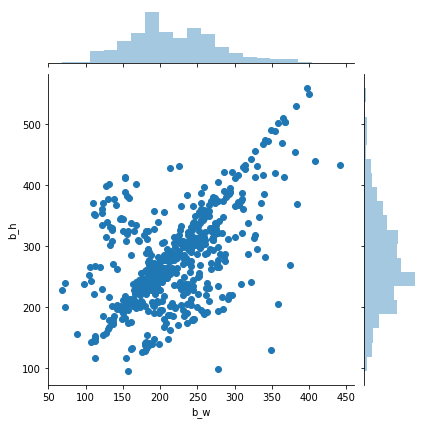

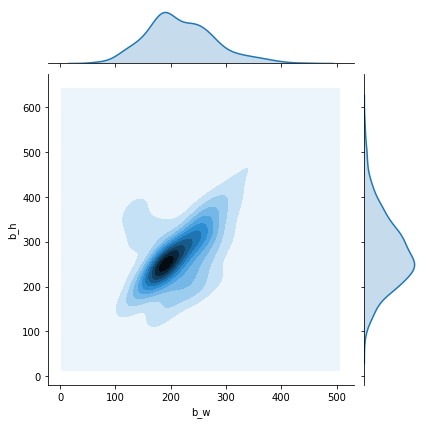

In [12]:
#Joint Plot of w and h
sns.jointplot(x="b_w", y="b_h", data=data)
sns.jointplot(x="b_w", y="b_h", data=data, kind='kde')

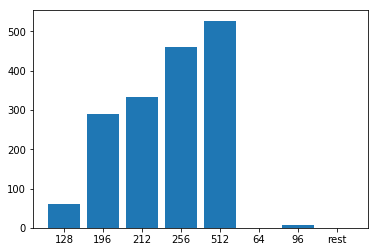

In [15]:
D = count_base_size(data["w"].tolist(), data["h"].tolist())
import collections
OD = collections.OrderedDict(sorted(D.items()))
plt.bar(range(len(OD)), OD.values(), align='center')  # python 2.x
plt.xticks(range(len(OD)), OD.keys())  # in python 2.x

plt.show()


In [16]:
data.columns

Index([u'filename', u'width', u'height', u'class', u'xmin', u'ymin', u'xmax',
       u'ymax', u'w', u'h', u'new_w', u'new_h', u'b_w', u'b_h', u'b_ar',
       u'b_area_scale', u'tf_scale'],
      dtype='object')

## Clusterring

### One by One

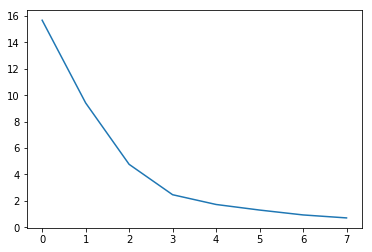

In [26]:

# 1 class AR
X = data.iloc[:,14].values
X = X.reshape(-1,1)


loss = []
from sklearn.cluster import KMeans
for i in range(2,10):
    K = KMeans(i, random_state=1)
    labels = K.fit(X)
    loss.append(labels.inertia_)

plt.plot(loss)

In [27]:
print data.columns[14]

from sklearn.cluster import KMeans
K = KMeans(4, random_state=1)
labels = K.fit(X)
labels.cluster_centers_

b_ar


array([[0.78240442],
       [1.2019433 ],
       [0.44523506],
       [2.76931501]])

In [33]:
x = data['w']/data['h']

data['b_ar'].corr(x)

0.9999999999999998

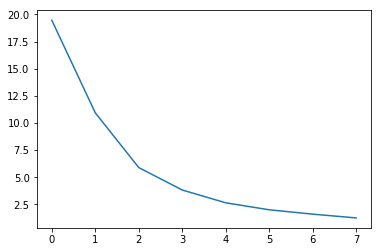

In [47]:

# 1 class TF_Scale
X = data.iloc[:,16].values
X = X.reshape(-1,1)


loss = []
from sklearn.cluster import KMeans
for i in range(2,10):
    K = KMeans(i, random_state=1)
    labels = K.fit(X)
    loss.append(labels.inertia_)

plt.plot(loss)

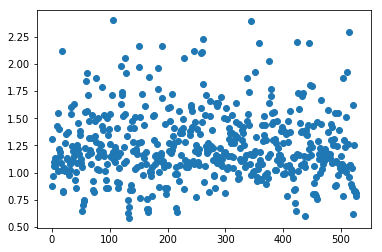

In [48]:
plt.plot(X, 'o')

In [25]:
print data.columns[16]

from sklearn.cluster import KMeans
K = KMeans(4, random_state=1)
labels = K.fit(X)
labels.cluster_centers_

tf_scale


array([[1.14693558],
       [2.01577181],
       [0.84961377],
       [1.49450567]])

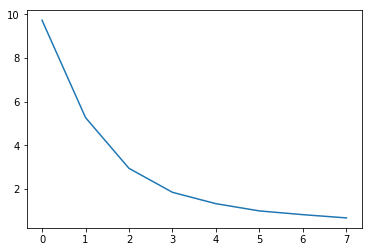

In [34]:

# 1 class area_Scale
X = data.iloc[:,15].values
X = X.reshape(-1,1)


loss = []
from sklearn.cluster import KMeans
for i in range(2,10):
    K = KMeans(i, random_state=1)
    labels = K.fit(X)
    loss.append(labels.inertia_)

plt.plot(loss)

In [35]:
print data.columns[15]

from sklearn.cluster import KMeans
K = KMeans(4, random_state=1)
labels = K.fit(X)
labels.cluster_centers_

b_area_scale


array([[1.31034603],
       [0.75597359],
       [1.00593311],
       [0.55433439]])

Index([u'b_w', u'b_h'], dtype='object')
[[234.92063492 280.95238095]
 [146.03174603 201.58730159]
 [207.93650794 173.01587302]
 ...
 [185.71428571 141.26984127]
 [180.95238095 130.15873016]
 [184.12698413 136.50793651]]


/home/yoda/tensorflow-1.9.0/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


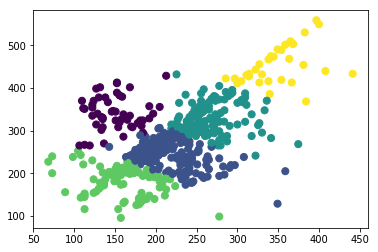

In [50]:
print data.columns[12:14]
X = data.as_matrix(columns=data.columns[12:14])
print X



from sklearn.cluster import KMeans
K = KMeans(5, random_state=0)
labels = K.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=labels.labels_,
            s=50, cmap='viridis');

In [46]:
out = labels.cluster_centers_

ar = out[:,0]/out[:,1]

print ar
print out

[0.44050928 0.86447933 0.81207427 0.86933814 0.76808116]
[[149.96947497 340.44566545]
 [211.8982906  245.11666667]
 [266.38636788 328.03202614]
 [159.46089466 183.42793009]
 [349.25595238 454.71230159]]


In [44]:
scale = out[:,1]*np.sqrt(ar)/196

In [45]:
scale

array([1.15284062, 1.16277069, 1.50819692, 0.872577  , 2.03321914])

In [49]:
#utility functions for K-means
import numpy as np


def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [53]:
cl = kmeans(X, 4)

In [54]:
print cl

[[157.5047619  196.82539683]
 [187.51746032 265.87301587]
 [271.42857143 334.12698413]
 [239.68253968 209.52380952]]


In [55]:
ar_iou = cl[:,0]/cl[:,1]

print ar_iou

[0.80022581 0.70528955 0.81235154 1.14393939]


In [57]:
scale_iou = cl[:,1]*np.sqrt(ar_iou)/196
print scale_iou

[0.89832056 1.13920509 1.53648203 1.14334901]
